# Process CF Parcel-level Annotations

1. Batch 1: 5,500 residential parcels from a simple random sample (3.5%) across each of the 51 income strata
2. Batch 2: ~3,000 residential parcels matching to AANC permits
3. Batch 3: ~16,000 residential parcels (latest estimate) according Neyman allocation per the power analysis to detect a significant effect in the permitted new small building proportion in low vs. high income neighborhoods

Outline:

Part 1: 
- Extract CF polygons -> This gives us a map of small buildings in each year (gdf)
- Identify newly constructed small buildings (entirely new, replacement of old building)

Part 2: 
- Permit-matching for newly constructed small buildings
- Outcome analysis 

In [86]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [87]:
# Load functions 
%run ADU_permit_matching-polygon-pipeline.ipynb import compare_building_footprint

# Load function to extract polygons from CF output


In [88]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

# Parameters
batch = 1
completion = 48
permit_matching = ['nearest-building', 'parcel-level'][1]
max_distance = 50

In [89]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

In [5]:
# Functions
def compare_smallbuildings(gdf, comp_list, name_list, model_params):
    """
    Compares the area of each building in gdf to the buildings in the GeoDataFrames in
    comp_list to check for expansions/constructions.
    """
    match_cols = ['APN', 'area', 'year', 'geometry'] +  [
        'expansion_{}_flag'.format(comp_name) for comp_name in name_list] + [
        'diff_{}_value'.format(comp_name) for comp_name in name_list]
    
    if gdf is None:
        return None
    
    for comp_name in name_list:
        gdf['expansion_{}_flag'.format(comp_name)] = None
        gdf['diff_{}_value'.format(comp_name)] = None
    
    for comp, comp_name in zip(comp_list, name_list):
        
        if comp is None:
            continue
        
        # Check expansion
        if len(gdf) > 0:
            comp['geometry_comp'] = comp['geometry']

            # Get polygon in comp gdf to which we compare each polygon
            comp = comp.reset_index()
            gdf = gdf.sjoin(comp[['geometry', 'geometry_comp']], how='left', predicate='intersects')
            gdf['iou_comp'] = gdf.apply(lambda row: (
                row['geometry'].intersection(comp.iloc[int(row['index_right'])]['geometry'])).area / 
                                    row['geometry'].area if pd.notnull(row['index_right']) else None, axis=1)

            # Have to account for potentially various matches for one inference (we compare to 
            # the one with highest overlap)
            gdf = gdf.sort_values('iou_comp', ascending=False)
            gdf.drop_duplicates(subset=['geometry'], keep='first', inplace=True)

            # Check expansion for each polygon
            gdf[['expansion_{}_flag'.format(comp_name), 'diff_{}_value'.format(comp_name)]] = gdf.apply(
                lambda row: compare_building_footprint(
                    base_geom=comp.iloc[int(row['index_right'])]['geometry'], 
                    new_geom=row['geometry'].union(comp.iloc[int(row['index_right'])]['geometry']), 
                    diff_type='protruding_poly', 
                    model_params=model_params, 
                    main_building_flag=False
                ) if pd.notnull(row['index_right']) else (True, True), 
                axis=1, result_type="expand")
            
            # Set area equal to the full polygon where we have a fully new small building
            gdf.loc[gdf['diff_{}_value'.format(comp_name)] == True, 'diff_{}_value'.format(comp_name)] = gdf.loc[
                gdf['diff_{}_value'.format(comp_name)] == True].to_crs('EPSG:26910')['geometry'].area

        gdf = gdf[match_cols]

    return gdf

def snap_permits(permit_data, small_build, max_distance):
    # 0. Prepare data
    permit_data_gdf = gpd.GeoDataFrame(
        permit_data, geometry='geometry_permit', crs='EPSG:4326')
    permit_data_gdf.reset_index(inplace=True, drop=True)
    permit_data_gdf['permit_index'] = permit_data_gdf.index
    n_permits = len(permit_data_gdf)
    
    small_build.reset_index(inplace=True, drop=True)
    small_build['sbuild_index'] = small_build.index

    # 1. Assign permits to nearest small building 
    # * Create a buffer around the small building
    small_build_buff = small_build.to_crs('EPSG:26910').copy()
    small_build_buff['centroid'] = small_build_buff['geometry'].centroid
    small_build_buff['geometry'] = small_build_buff.buffer(max_distance)

    # * Join permits and small buildings
    permits_snap = permit_data_gdf[
        ['OBJECTID_left', 'issue_year', 'geometry_permit', 'permit_index']].to_crs('EPSG:26910').sjoin(
        small_build_buff[['geometry', 'centroid', 'sbuild_index']], how='left', predicate='intersects')

    # * Drop permits that do not match to buffered buildings
    permits_snap = permits_snap.loc[~permits_snap['index_right'].isna()]

    # * Compute distance
    permits_snap['distance'] = permits_snap['geometry_permit'].distance(permits_snap['centroid'])

    # * Order permits by closest distance and drop duplicates
    permits_snap.sort_values('distance', ascending=True, inplace=True)
    permits_snap.drop_duplicates(subset='permit_index', keep='first', inplace=True)
    assert len(permits_snap) <= len(permits_snap['permit_index'].unique())

    # -- 2. Define permitted new small buildings
    permits_snap['index_right'] = permits_snap['index_right'].astype(int)
    permits_snap['sbuild_index'] = permits_snap['sbuild_index'].astype(int)

    sbuild_permitted = pd.merge(
        small_build, permits_snap[['sbuild_index', 'OBJECTID_left', 'issue_year']], 
        how='left', on='sbuild_index', validate='one_to_many')
    sbuild_permitted['permitted'] = ~sbuild_permitted['OBJECTID_left'].isna()

    # Keep only one permit per building (to not duplicate small buildings)
    sbuild_permitted.sort_values('permitted', ascending=False, inplace=True)
    sbuild_permitted.drop_duplicates('sbuild_index', keep='last', inplace=True)

    return sbuild_permitted

## 1. Check batch completion and extract CF polygons

In [7]:
# Load batch data and batch query
# * Submitted parcels
submitted_parcels = glob.glob(os.path.join(CF_FP, 'images', 'Batch{}'.format(batch), 'images', '*.png'))
submitted_parcels = [p.split(os.path.sep)[-1].replace('.png', '') for p in submitted_parcels]

In [8]:
# Load extracted polygons (run separate notebook)
# Gdf with APN, year, area, building geometry
sbuild = gpd.read_file(
    os.path.join(CF_FP, 'results', 'Batch{}_{}'.format(batch, completion), 'extracted_poly'))

In [133]:
sbuild

,APN,year,area,geometry
0,29930028,2020,24.255,"POLYGON ((-121.96208 37.31025, -121.96204 37.3..."
1,29930028,2016,24.660,"POLYGON ((-121.96206 37.31025, -121.96202 37.3..."
2,42910002,2016,55.890,"POLYGON ((-121.90618 37.30426, -121.90611 37.3..."
3,42910002,2020,55.890,"POLYGON ((-121.90619 37.30427, -121.90612 37.3..."
4,44626008,2016,61.965,"POLYGON ((-121.90371 37.28985, -121.90365 37.2..."
...,...,...,...,...
1146,42950063,2020,59.445,"POLYGON ((-121.91191 37.30162, -121.91182 37.3..."
1147,24527064,2020,22.725,"POLYGON ((-121.87711 37.38199, -121.87708 37.3..."
1148,24527064,2016,23.670,"POLYGON ((-121.87716 37.38194, -121.87712 37.3..."
1149,43909027,2020,69.210,"POLYGON ((-121.89206 37.29308, -121.89201 37.2..."


In [9]:
# * Annotated parcels
annotated_parcels_files = glob.glob(
    os.path.join(CF_FP, 'exports', 'Batch{}_{}'.format(batch, completion), '*.json'))
annotated_parcels = [p.split(os.path.sep)[-1].replace('.json', '') for p in annotated_parcels_files]

smallbuild_parcels = sbuild['APN'].unique()

# Generate shp of annotated area
annotated_parcels_shp = sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'].isin(annotated_parcels)].copy()

In [10]:
print('[INFO] Annotated {} parcels out of {} submitted parcels for batch {} at {}% completion'.format(
    len(annotated_parcels), len(submitted_parcels), batch, completion))
print('[INFO] {} parcels including small buildings'.format(len(smallbuild_parcels)))

[INFO] Annotated 2666 parcels out of 5541 submitted parcels for batch 1 at 48% completion
[INFO] 566 parcels including small buildings


### 1.1 Generate dataframe of small building counts per parcel and CF area coverage

In [29]:
parcel_density = sbuild.groupby(['APN', 'year'])['area'].count().reset_index()
parcel_density = parcel_density.pivot(index='APN', columns='year', values='area').reset_index()

parcel_density = pd.DataFrame({'APN': annotated_parcels}).merge(
    parcel_density, how='left', validate='one_to_one')

parcel_density.fillna(0, inplace=True)
parcel_density.to_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'parcel_density.csv'), index=False)

In [94]:
CF_area_coverage = sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'].isin(annotated_parcels)]
CF_area_coverage.to_file(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'CF_area_coverage'))

## 2. Identify newly constructed small buildings

In [11]:
# sbuild_2020_compared is a gdf of 2020 buildings and whether they are new constructions
sbuild_2020_compared = gpd.GeoDataFrame()

for parcel_apn in tqdm(sbuild['APN'].unique()):
    # Get annual small building gdfs
    parcel_sbuild = sbuild.loc[sbuild['APN'] == parcel_apn].copy()
    parcel_sbuild_2020 = parcel_sbuild.loc[parcel_sbuild['year'] == '2020'].copy()
    parcel_sbuild_2016 = parcel_sbuild.loc[parcel_sbuild['year'] == '2016'].copy()
    
    # Check for new constructions
    parcel_sbuild_2020 = compare_smallbuildings(
        gdf=parcel_sbuild_2020, comp_list=[parcel_sbuild_2016], 
        name_list=['2016'], 
        model_params={'area_threshold_main': None, 'area_threshold_small': 20, 
                      'negative_buffer': 0.5})
    
    # Append
    sbuild_2020_compared = pd.concat([sbuild_2020_compared, parcel_sbuild_2020])
    
if 'index_right' in sbuild_2020_compared.columns:
    sbuild_2020_compared.drop('index_right', inplace=True, axis=1)

100%|██████████| 566/566 [01:14<00:00,  7.65it/s]


In [12]:
print('[INFO] We have {} small building annotations across {} parcels for both years.'.format(
    len(sbuild), len(smallbuild_parcels)))
print('[INFO] We have {} small building annotations for 2020; and '
      'identify {} of these to be built after 2016'.format(
      len(sbuild.loc[sbuild['year'] == '2020']), sbuild_2020_compared['expansion_2016_flag'].sum()))

[INFO] We have 1151 small building annotations across 566 parcels for both years.
[INFO] We have 585 small building annotations for 2020; and identify 50 of these to be built after 2016


In [69]:
sbuild_2020_compared[['APN', 'area', 'year', 'expansion_2016_flag']].to_csv(os.path.join(
    OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'sbuild_2020_compared.csv'), index=False)

### 2.1 Check whether we pass test cases

In [13]:
test_cases = {
    'true(new)': ['45120021', '44732030', '43933037', '44626011', '46432056', '43428123', 
                  '46207052', '43917140', '27453041', '26462005', '30341002', '30334023', 
                  '29928063', '37317034', '27726026', '30330004', 
                  '30327016', '24960051', '24529043', '46227003', '26123040', 
                 ],
    'true(replace)': ['43406087', '42933015', '27409002', '26435035', '24509006', '26117066', '24902060'],
    'false': ['44708058', '44629050', '43917076', '43409088', '42929009', '44626008', 
              '41944094', '42926032', '43915071', '42903018', '46714029', '44706008',
              '43920020', '42940022', '44627033', '46705041', '46707017', '43946024', 
              '43429050', '42108046', '42923006', '43903050', '42117003', '42950063',
              '43422021', '41917050', '42916008', '43424064', '42950046', '44638005', 
              '44709053', '45515080', '44232048', '42947023', '43925046', '43910021', 
              '46237003', '42908005', '44627041', '42906013', '43914059', '42924011', 
              '42114072', '27445085', '40304054', '24953062']
}

In [14]:
new_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(new)'])].copy()
new_add = new_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
new_add['expansion'] = new_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

print('[INFO] True (new) additions: {}/{}'.format(
    new_add['expansion'].sum(), len(new_add)))

replace_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(replace)'])].copy()
replace_add = replace_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
replace_add['expansion'] = replace_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

print('[INFO] True (replace) additions: {}/{}'.format(
    replace_add['expansion'].sum(), len(replace_add)))

false_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['false'])].copy()
false_add = false_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
false_add['expansion'] = false_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

print('[INFO] False additions: {}/{}'.format(
    len(false_add) - false_add['expansion'].sum(), len(false_add)))

[INFO] True (new) additions: 20/21
[INFO] True (replace) additions: 6/7
[INFO] False additions: 45/46


### 2.2 Test specific cases

In [34]:
parcel_apn = '27409002'
parcel_sbuild = sbuild.loc[sbuild['APN'] == parcel_apn].copy()
parcel_sbuild_2020 = parcel_sbuild.loc[parcel_sbuild['year'] == '2020'].copy()
parcel_sbuild_2016 = parcel_sbuild.loc[parcel_sbuild['year'] == '2016'].copy()

# Check for new constructions
parcel_sbuild_2020 = compare_smallbuildings(
    gdf=parcel_sbuild_2020, comp_list=[parcel_sbuild_2016], 
    name_list=['2016'], 
    model_params={'area_threshold_main': None, 'area_threshold_small': 20, 
                  'negative_buffer': 0.5})

In [35]:
parcel_sbuild_2020

,APN,area,year,geometry,expansion_2016_flag,diff_2016_value
865,27409002,37.485,2020,"POLYGON ((-121.92719 37.33260, -121.92723 37.3...",False,0.0


## 3. Permit-matching
Can be performed at the parcel-level or via assigning permits to the nearest small building.

Output is `new_sbuild_2020`, a gdf of 

In [15]:
if permit_matching not in ['nearest-building', 'parcel-level']:
    raise Exception('[ERROR] Check permit matching type')

In [16]:
if permit_matching == 'nearest-building':
    # Snap permits to nearest small building (within a threshold)
    snap_path = os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion),
                             'permit-matching-nearest-{}.csv'.format(max_distance)) 
    
    if not os.path.exists(os.path.dirname(snap_path)):
        os.makedirs(os.path.dirname(snap_path))
    
    if os.path.exists(snap_path):
        print('[INFO] Loading nearest-building matching using max distance of {}'.format(max_distance))
        new_sbuild_2020 = gpd.read_file(snap_path)
    else:
        # Assign permits to nearest building   
        sbuild_2020_permitted = snap_permits(
            permit_data=permits_2015_20, small_build=sbuild_2020_compared, max_distance=max_distance)
        print('[INFO] {} permits assigned to small buildings using max distance of {}'. format(
            sbuild_2020_permitted['permitted'].sum(), max_distance))
        
        # Aggregate at the parcel level (just consider parcel growth)
        new_sbuild_2020 = sbuild_2020_permitted.copy()
        new_sbuild_2020 = new_sbuild_2020.loc[new_sbuild_2020['expansion_2016_flag'] == True].copy()
        new_sbuild_2020['expansion_2016_flag'] = new_sbuild_2020['expansion_2016_flag'].astype(int)
        
        #new_sbuild_2020['permitted'] = ~new_sbuild_2020['OBJECTID_left'].isna()
        new_sbuild_2020 = new_sbuild_2020.groupby(['APN'])[
            ['expansion_2016_flag', 'permitted']].sum().reset_index()

        new_sbuild_2020.rename(
            columns={'expansion_2016_flag': 'count_new_sbuild', 
                     'permitted': 'count_new_sbuild_permitted'}, inplace=True)
        new_sbuild_2020['count_new_sbuild_unpermitted'] = new_sbuild_2020[
            'count_new_sbuild'] - new_sbuild_2020['count_new_sbuild_permitted']
        assert new_sbuild_2020['count_new_sbuild_unpermitted'].min() >= 0

        # Save
        new_sbuild_2020.to_csv(snap_path)

In [17]:
if permit_matching == 'parcel-level':
    """
    Counts the number of newly constructed small buildings and the number of AANC permits issue
    during 2015-20 to determine what proportion are permitted vs unpermitted. 
    """
    
    # Get number of 2015-20 AANC permits per parcel
    parcel_permit_counts = permits_2015_20.copy()
    parcel_permit_counts = parcel_permit_counts.groupby('APN_parcel')['OBJECTID_left'].count().reset_index()
    parcel_permit_counts.rename(
        columns={'APN_parcel': 'APN', 'OBJECTID_left': 'pcount_2015_20'}, inplace=True)
    
    # Get new small building counts for each parcel
    new_sbuild_2020 = sbuild_2020_compared.loc[sbuild_2020_compared['expansion_2016_flag'] == True].copy()
    new_sbuild_2020 = new_sbuild_2020.groupby('APN')['expansion_2016_flag'].count().reset_index()
    new_sbuild_2020.rename(columns={'expansion_2016_flag': 'count_new_sbuild'}, inplace=True)
    
    # Merge permit and small building data
    new_sbuild_2020 = pd.merge(
        new_sbuild_2020, parcel_permit_counts[['APN', 'pcount_2015_20']], on='APN', 
        how='left', validate='one_to_one')

    # Fill parcel columns with zeros
    new_sbuild_2020[['pcount_2015_20']] = new_sbuild_2020[['pcount_2015_20']].fillna(value=0)

    # Compute unpermitted and permitted new small buildings at the parcel level
    new_sbuild_2020['count_new_sbuild_permitted'] = new_sbuild_2020.apply(
        lambda row: min(row['count_new_sbuild'], row['pcount_2015_20']), axis=1)
    new_sbuild_2020['count_new_sbuild_unpermitted'] = new_sbuild_2020[
        'count_new_sbuild'] - new_sbuild_2020['count_new_sbuild_permitted']

    assert new_sbuild_2020['count_new_sbuild_unpermitted'].sum() + new_sbuild_2020[
        'count_new_sbuild_permitted'].sum() == new_sbuild_2020['count_new_sbuild'].sum()
    
    new_sbuild_2020.to_csv(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion),
                         'permit-matching-apns.csv'), index=False)

In [18]:
# Print stats
print('[INFO] Permitted small building constructions: {}'.format(
    new_sbuild_2020['count_new_sbuild_permitted'].sum() ))
print('[INFO] Unermitted small building constructions: {}'.format(
    new_sbuild_2020['count_new_sbuild_unpermitted'].sum() ))
print('[INFO] Total small building constructions: {}'.format(
    new_sbuild_2020['count_new_sbuild'].sum() ))

[INFO] Permitted small building constructions: 5.0
[INFO] Unermitted small building constructions: 45.0
[INFO] Total small building constructions: 50


## 4. Outcome analysis (equity impact)

In [45]:
# Generate quartile and neighborhood columns for each CBG
if 'neighborho' in cbg_income_2016_SJ.columns:
    cbg_income_2016_SJ.drop('neighborho', axis=1, inplace=True)

quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

cbg_income_2016_SJ['neighborhood'] = cbg_income_2016_SJ['quartile'].apply(
    lambda quartile: quartile_neighborhoods[quartile])

cbg_income_2016_SJ['quartile'] = cbg_income_2016_SJ['quartile'].apply(
    lambda quartile: quartile_names[quartile])

sj_parcels_cbgs = pd.merge(
    sj_parcels_cbgs, cbg_income_2016_SJ[['GEOID', 'neighborhood', 'quartile']], how='left', 
    validate='many_to_one')

# Add GEOID, neighborhood and quartile
outcome = new_sbuild_2020.copy()
outcome = pd.merge(
    outcome, sj_parcels_cbgs[['APN', 'GEOID', 'neighborhood', 'quartile']], 
    how='left', validate='one_to_one')

At the quartile level
        quartile  count_new_sbuild_permitted  count_new_sbuild_unpermitted  \
0            Low                           3                             8   
1   Low-Moderate                           2                             6   
2  High-moderate                           1                            15   
3           High                           5                            10   

   total_change  permitted_proportion  
0            11              0.272727  
1             8              0.250000  
2            16              0.062500  
3            15              0.333333  


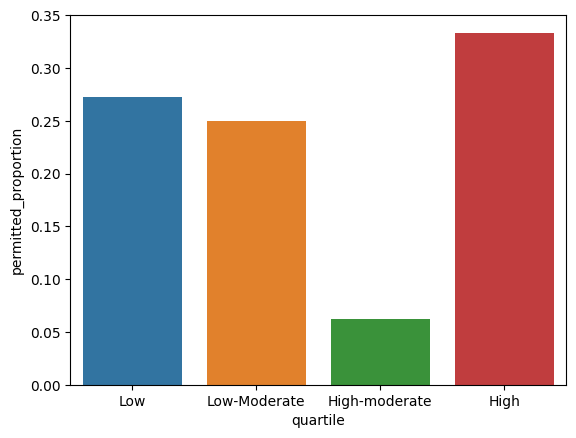

In [102]:
# Aggregate by quartile
outcome_quartile = outcome.groupby('quartile')[
    ['count_new_sbuild_permitted', 'count_new_sbuild_unpermitted']].sum().reset_index()

outcome_quartile['total_change'] = outcome_quartile['count_new_sbuild_permitted'] + outcome_quartile[
    'count_new_sbuild_unpermitted']
outcome_quartile['permitted_proportion'] = outcome_quartile.apply(
    lambda row: row['count_new_sbuild_permitted'] / row['total_change'], axis=1)

print('At the quartile level')
print(outcome_quartile)
sns.barplot(outcome_quartile, x='quartile', y='permitted_proportion')
plt.show()

In [103]:
print('[INFO] {} small buildings in 2020; {} newly constructed small buildings in 2020'.format(
    len(sbuild_2020_compared), sbuild_2020_compared['expansion_2016_flag'].sum()))

print('[INFO] {} permits issued during 2015-20'.format(len(permits_2015_20)))

print('[INFO] Number of permitted new small buildings: {}'.format(
    new_sbuild_2020['count_new_sbuild_permitted'].sum()))

[INFO] 585 small buildings in 2020; 50 newly constructed small buildings in 2020
[INFO] 5140 permits issued during 2015-20
[INFO] Number of permitted new small buildings: 11


## 5. Power analysis inputs

### 5.1 SRS

In [79]:
# Distribution of number of new small buildings (per CF annotations) by neighborhood
parcel_density = pd.read_csv(os.path.join(
    OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'parcel_density.csv'))
sbuild_2020_compared_df = pd.read_csv(os.path.join(
    OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'sbuild_2020_compared.csv'))

In [83]:
# Compute new small buildings across all annotated parcels
sb_growth = sbuild_2020_compared.copy()
sb_growth['expansion_2016_flag'] = sb_growth['expansion_2016_flag'].astype(int)
sb_growth = sb_growth.groupby('APN')['expansion_2016_flag'].sum().reset_index()

sb_growth = pd.merge(parcel_density, sb_growth, on='APN', how='left', validate='one_to_one')
sb_growth.fillna(0, inplace=True)

In [85]:
# Add GEOID
sb_growth = pd.merge(sb_growth, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

# Add neighborhood
high_income_cbgs = cbg_income_2016_SJ.loc[cbg_income_2016_SJ['neighborhood'] == 'High']['GEOID'].unique()
print('Number of high income CBGS (defined by 75%): {}'.format(len(high_income_cbgs)))

sb_growth['neighborhood'] = sb_growth['GEOID'].apply(
    lambda geoid: 'high' if geoid in high_income_cbgs else 'low')

sb_growth.groupby(['neighborhood', 'expansion_2016_flag'])['APN'].count().reset_index()

Number of high income CBGS (defined by 75%): 160


,neighborhood,expansion_2016_flag,APN
0,high,0.0,856
1,high,1.0,15
2,low,0.0,1760
3,low,1.0,35


### 5.2 Neyman

## 6. Explore

In [ ]:
# Small building sizes

In [107]:
50 / 2666 * 150000

2813.2033008252065

False positives in CF annotations

In [122]:
new_sbuild_2020

,APN,count_new_sbuild,pcount_2015_20,count_new_sbuild_permitted,count_new_sbuild_unpermitted
0,1511081,1,0.0,0.0,1.0
1,24509006,1,0.0,0.0,1.0
2,24529043,1,0.0,0.0,1.0
3,24902060,1,0.0,0.0,1.0
4,24927036,1,0.0,0.0,1.0
5,24958007,1,0.0,0.0,1.0
6,24960051,1,0.0,0.0,1.0
7,25404032,1,0.0,0.0,1.0
8,26117066,1,0.0,0.0,1.0
9,26123040,1,0.0,0.0,1.0


In [105]:
new_sbuild_2020 = pd.read_csv(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion),
                         'permit-matching-apns.csv'))

In [112]:
#fp = gpd.clip(gpd.GeoDataFrame(permits_2015_20, geometry='geometry_permit', crs='EPSG:4326'), 
#              CF_area_coverage)

In [125]:
fp = permits_2015_20.loc[permits_2015_20['APN_parcel'].isin(annotated_parcels)]

In [129]:
# Remove permits we did match to small building constructions
perm = new_sbuild_2020.loc[new_sbuild_2020['count_new_sbuild_permitted'] >0]
fp = fp.loc[~fp['APN_parcel'].isin(perm['APN'].unique())]

In [132]:
fp.loc[fp['SQUAREFOOT'] >0]

,OBJECTID_left,FACILITYID,INTID_left,ADDRESS,APN,APPLICANT,CONTRACTOR,WORKDESC,SUBDESC,PERMITAPPROVAL,...,PLANMOD,LASTUPDATE_right,NOTES_right,COVERED,SHAPE_Length,SHAPE_Area,geometry_parcel,issue_date_converted,foldernum_year,issue_year
36,A_5391,7465,7465,"1737 LAURELWOOD DR , SAN JOSE CA 95125-4952",44609018,PARDEN CONSTRUCTION,PARDEN CONSTRUCTION,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,407.055603,10270.180619,POLYGON ((-121.91115744896378 37.2831176858588...,2020-07-20 00:00:00,2019,2020
205,A_23904,22971,22971,"1561 VIRGINIA PL 2 , SAN JOSE CA 95116",48145016,SOLANO MARIA C,NaN,New Construction,2nd Unit Added,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,400.727444,7519.883462,POLYGON ((-121.85230439827797 37.3439064491545...,2020-10-27 00:00:00,2019,2020
9119,E_25390,25355,25355,"2658 HILL PARK DR , SAN JOSE CA 95124-1734",44228004,MAILEY NICHOLAS M AND SIMMONS JENNIFER L,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,324.614331,6138.397591,POLYGON ((-121.9142774644383 37.27454989036049...,2015-02-20 00:00:00,2015,2015
9629,E_28998,14242,14242,"1532 NEWPORT AV , SAN JOSE CA 95125-3331",42930012,FUNCTIONAL ART CONSTRUCTION INC,FUNCTIONAL ART CONSTRUCTION INC,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,471.818182,12406.223824,POLYGON ((-121.8989665273595 37.29974057954877...,2016-01-27 00:00:00,2015,2016
9681,E_29397,29373,29373,"1410 DRY CREEK RD , SAN JOSE CA 95125-4616",44626011,BLACK MOUNTAIN CONSTRUCTION INC SASHA CUKIC,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,415.951355,8977.723505,POLYGON ((-121.90324763722893 37.2903764819459...,2015-10-22 00:00:00,2015,2015
9788,E_30351,30331,30331,"7078 BOLLINGER RD , SAN JOSE CA 95129-2849",37201030,MICHAEL'S BUILDER LIZHEN WU,MICHAEL'S BUILDER,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,432.807014,10197.786544,POLYGON ((-122.02858952398456 37.3113396937153...,2015-10-01 00:00:00,2015,2015
10459,E_35326,35355,35355,"1810 GREENCREEK DR , SAN JOSE CA 95124-1120",44208047,LOAYZA'S LANDSCAPING POOLS et al,LOAYZA'S LANDSCAPING POOLS,Additions/Alterations,Single-Family,"B-Complete, E-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,379.419049,7914.873395,POLYGON ((-121.92108076490867 37.2811751958070...,2017-05-05 00:00:00,2017,2017
10827,E_37931,38007,38007,"2285 COTTLE AV , SAN JOSE CA 95125-4004",43931006,VOSBURGH TIM AND TANYA,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,388.763234,7218.698644,POLYGON ((-121.89326262335928 37.2868591675550...,2018-06-05 00:00:00,2018,2018
10916,E_38517,38613,38613,"943 RIVERSIDE DR , SAN JOSE CA 95125-2269",26452076,MIRON-CONK PETER J AND NORMA TRUSTEE,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,621.232402,12601.208258,POLYGON ((-121.90213267467782 37.3147005719889...,2018-02-26 00:00:00,2017,2018
11065,E_39548,39680,39680,"1399 OAK KNOLL DR , SAN JOSE CA 95129-4171",37817045,PAN WEN-TAO AND LEE CHIAO-CHEN,NaN,Additions/Alterations,Single-Family,"B-Complete, E-Complete, M-Complete, P-Complete",...,NaN,2005-10-25T12:21:45+00:00,NaN,NaN,333.665854,6469.205590,POLYGON ((-121.99985257573711 37.2979364329208...,2018-02-21 00:00:00,2018,2018


## Test functions

In [6]:
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [7]:
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_res = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Permits
sj_parcel_permit = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])

In [42]:
parcel_apn='70617035'
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, _, permits_parcel = parcel_level_data(
    parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

In [43]:
inferred_buildings_2020_parcel['APN'] = parcel_apn
inferred_buildings_2020_parcel['year'] = '2020'
parcel_sbuild_2020 = compare_smallbuildings(
    gdf=inferred_buildings_2020_parcel, comp_list=[inferred_buildings_2016_parcel], 
    name_list=['2016'], 
    model_params={'area_threshold_main': None, 'area_threshold_small': 15, 
                  'negative_buffer': 0.5})

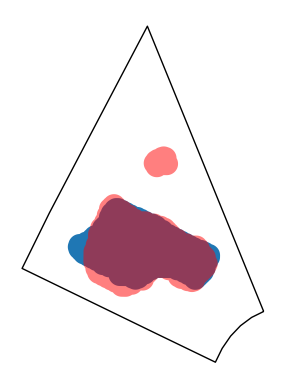

In [46]:
fig, ax = plt.subplots()
parcel_bounds.plot(ax=ax, facecolor='none')
inferred_buildings_2016_parcel.plot(ax=ax)
inferred_buildings_2020_parcel.plot(ax=ax, color='red', alpha=0.5)
ax.axis('off')
plt.show()

In [45]:
parcel_sbuild_2020

,APN,area,year,geometry,expansion_2016_flag,diff_2016_value
0,70617035,178.435864,2020,"POLYGON ((-121.76412 37.22964, -121.76412 37.2...",False,9.29678
1,70617035,15.941208,2020,"POLYGON ((-121.76402 37.22976, -121.76402 37.2...",True,15.941208
